# Introduction

Notre projet portait sur le traitement de données textuelles.
Nous sommes parties d'une base de données extraite sur Kaggle, regroupant 65 535 tweets en anglais postés entre avril 2009 et mai 2009. 


A partir de cette base, nous avons repéré différentes thématiques récurrentes dans ces tweets (par exemple la météo, le travail...). Notre objectif était donc, à partir du texte du tweet, de prédire la thématique auquel il appartenait.
Pour cela, nous avons suivi une logique de classification supervisée, les classes étant les thématiques rencontrées dans les tweets. 
Nous avons choisi cette approche car nous voulions choisir nous-mêmes les catégories qui seraient utilisées pour la classification. En effet, nous avons préféré une approche de classification avec des étiquettes au lieu de regrouper les tweets dans de quelconques clusters.

Plus généralement, le thème du Natural Language Processing nous semblait intéressant à étudier, car il est très utilisé dans les entreprises (par exemple analyse de sentiment en Marketing).

# Data preprocessing.

### Importation des packages.

In [1]:
import numpy as np
import pandas as pd
import sklearn

import nltk

import matplotlib.pyplot as plt
from sklearn.model_selection import train_test_split
from sklearn.ensemble import RandomForestClassifier
from sklearn.neighbors import KNeighborsClassifier


from sklearn.metrics import roc_curve, auc
from sklearn.naive_bayes import MultinomialNB
from sklearn.feature_extraction.text import CountVectorizer
from sklearn.metrics import confusion_matrix
from sklearn.preprocessing import label_binarize
from sklearn.preprocessing import LabelBinarizer

Définition des différentes thématiques, identifiées par mots clés.

In [2]:
meteo = ['SPRING','FALL','AUTUMN','SUMMER','WINTER','COLD','RAIN','RAINING','SNOW','SNOWING','SUN',
'SHINE','SHINING','FREEZING','FREEZE','HOT','STIFFLING']

travail = ['SCHOOL', 'HOMEWORKS', 'LEARN', 'LEARNING', 'FINALS', 'HIGHSCHOOL','COLLEGE', 'JUNIOR',
           'HOMEWORK', 'WORK']
nourriture = [ 'ATE', 'EAT', 'FOOD','CHEETOS', 'VEGETABLES', 'FRUITS', 'MILK', 'TASTY',
              'TASTIEST', 'DELICIOUS', 'YUMMY']
sport = ['EXERCISING', 'WORKOUT', 'RUNNING', 'SHOWER', 'SPORT', 'BODY']


Importation des données et renommage des colonnes.

In [3]:
data_columns = ["target", "ids", "date", "flag", "user", "text"]
databrut= pd.read_excel("C:/Users/Marie-Alix Baduel/Desktop/Twitterexcel.xls", names= data_columns)

In [4]:
databrut['category']= ''
databrut.drop(columns=['target'], inplace=True)
databrut.drop(columns=['flag'], inplace=True)

Pour traiter plus facilement nos données textes (homogénéisation du texte), mise en majuscule.

In [5]:
databrut['text'] = databrut['text'].str.upper()

Afin de pouvoir analyser les tweets, nous devons traiter le texte à travers plusieurs procédés.
Tout d'abord, nous devons "tokeniser" l'ensemble des tweets. Il s'agit de transformer un texte en un série de tokens individuels. Un token représente un mot ou un signe de ponctuation et le but ici est de séparer tous les mots bien distinctement afin de pouvoir mieux les classifier. Nous utilisons ici l'outil tokenizer qui va tokeniser notre base de tweets à partir d'un ensemble de règles grammaticales du langage anglais.Nous avons choisi de séparer les mots en fonction des espaces blancs.

In [6]:
tokenizer= nltk.tokenize.WhitespaceTokenizer()

In [7]:
texte_tok= list()
for i in databrut['text']: 
    x= tokenizer.tokenize(i)
    texte_tok.append(x)

In [8]:
databrut['text']= texte_tok

## Stemming

Le stemming consiste à réduire la forme d'un mot de manière à ne conserver que sa racine. Ainsi, pour chaque mot, on supprime sa conjugaison, son genre ainsi que le nombre. Le but du stemming est de regrouper les nombreuses variantes d'un mot comme un seul et même mot. Cela nous permet de réduire la taille du vocabulaire mais aussi de mieux repérer les thématiques abordées.
Nous avons choisi d'utiliser le stemming plutôt que le lemmatizing car cela est plus simple et le stemming donne des résultats plus rapides. Le lemmatizing est un outils linguistique nécessitant l'usage du dictionnaire car son utilisation est plus complexe (contrairement au stemming, la lemmatisation prend en compte la morphologie du mot et ne le 'coupe' pas).

In [9]:
import nltk
stemmer= nltk.stem.PorterStemmer()
lemmatizer = nltk.stem.WordNetLemmatizer()

In [10]:
text_stemmed = list()

In [11]:
def stemming(text):
    text_stemmed = " ".join(stemmer.stem(x) for x in text)
    return(text_stemmed)

In [12]:
%%time
for i in range(len(databrut['text'])):
    databrut['text'][i] = stemming(databrut['text'][i])
    
#ESSAYER DE DIMINUER LE TIME

<timed exec>:2: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy


Wall time: 1min 51s


Pour pouvoir analyser nos textes auxquels on a appliqué le stemmer, il faut aussi l'appliquer sur nos catégories, et ainsi
pouvoir retrouver nos thématiques dans nos tweets. 

In [13]:
for i in range(len(meteo)):
    meteo[i]= stemmer.stem(meteo[i])

for i in range(len(travail)):
    travail[i]= stemmer.stem(travail[i])

for i in range(len(nourriture)):
    nourriture[i]= stemmer.stem(nourriture[i])

for i in range(len(sport)):
    sport[i]= stemmer.stem(sport[i])

# Machine learning

## Classification de nos tweets.


Nous avons dans un premier temps classifié tous nos tweets, aussi bien ceux devant servir à l'apprentissage (base train) 
que ceux devant servir au test (pour pouvoir comparer nos résultats et l'efficacité de nos modèles de classification). 
On conserve nos 4 catégories (météo, travail, nourriture et sport) ainsi qu'une 5e catégorie (sans catégorie) pour les tweets n'ayant pas été attribués aux 4 premières catégories.

In [14]:
%%time
for i in range(len(databrut['text'])):
    for j in meteo: 
        if j in databrut['text'][i]:
            databrut['category'][i]='météo'
            
for i in range(len(databrut['text'])):
    for j in travail: 
        if j in databrut['text'][i]:
            databrut['category'][i]='travail'
            
for i in range(len(databrut['text'])):
    for j in nourriture: 
        if j in databrut['text'][i]:
            databrut['category'][i]='nourriture'
            
for i in range(len(databrut['text'])):
    for j in sport: 
        if j in databrut['text'][i]:
            databrut['category'][i]='sport'
            

for i in range(len(databrut['text'])):
    if databrut['category'][i]== '':
        databrut['category'][i]='sanscatégorie'

<timed exec>:4: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
<timed exec>:9: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
<timed exec>:14: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
<timed exec>:19: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
<timed exe

Wall time: 1min 18s


In [15]:
databrut["category"].value_counts()

sanscatégorie    45541
travail           7306
nourriture        6837
météo             4377
sport             1474
Name: category, dtype: int64

On constate que nos tweets sont assez inégalement répartis entre nos différentes catégories, et que la catégorie 
'sans catégorie' est largement majoritaire.

On définit la variable utilisée (le texte du tweet) ainsi que ce qu'on cherche à prédire (la catégorie).
Puis on divise notre base de données entre le jeu d'entraînement et le jeu de test. 
On affecte 80% de la base à l'entraînement, et 20% au test. 

In [16]:
X=databrut['text']
Y= databrut['category']

X_train, X_test, Y_train, Y_test = train_test_split(X, Y, test_size = 0.2, random_state=5)
print(X_train.shape)
print(X_test.shape)
print(Y_train.shape)
print(Y_test.shape)

(52428,)
(13107,)
(52428,)
(13107,)


# Modèles de classification.

Pour classifier nos tweets, on va utiliser différentes méthodes: Naïves Bayes, la Random Forest et le K_nearest_neighbors. 
Ainsi, on pourra ensuite déterminer quel modèle est le plus efficace pour classifier les tweets.

 ## Naive Bayes

On ne peut pas appliquer les méthodes de classification directement sur des variables caractères. Il faut donc vectoriser
les textes de nos tweets (chaque mot correspondant à une suite particulière de 0 et de 1) et appliquer ensuite nos modèles sur
ces textes vectorisés.

In [17]:
vectorizer= CountVectorizer()

In [18]:
X_train_v= vectorizer.fit_transform(X_train)

In [19]:
clf = MultinomialNB().fit(X_train_v, Y_train)

In [20]:
X_test_v = vectorizer.transform(X_test)

On prédit la classe sur la partie test.

In [21]:
Y_predicted = clf.predict(X_test_v)

## KNN Classifier.

Par défaut, le classifieur KNN est implémenté pour 3 voisins. Nous faisons une analyse graphique de l'accuracy balanced en fonction du nombre de voisins dans le classifieur KNN pour déterminer le nombre de voisins optimal.  

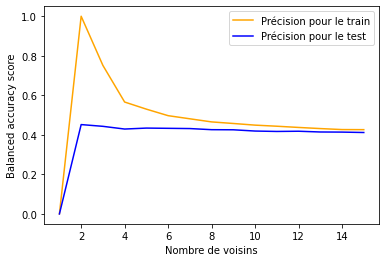

In [22]:
#IMAGE AUDE RFC.

from IPython.display import Image
Image(r"C:\Users\Marie-Alix Baduel\Desktop\M2 TIDE\nb de voisins.png")

Nous avons fait figurer le code correspondant au graphique ci-dessous. Le temps de calcul est d'environ 30min.

In [23]:
%%time
# on crée deux vecteurs composés de 15 zéros; lors de la boucle, les valeurs calculées de l'accuracy pour le train
# (acc_train_vector) et pour le test (acc_test_vector) seront implémentées dans les vecteurs et remplaceront les zéros.
# On représentera ensuite les valeurs de ces vecteurs sur un graphique en fonction du nombre de voisins afin de déterminer 
# pour le train et le test quel nombre de voisins maximise l'accuracy (précision).
# Notre boucle testera le nombre de voisins pour i appartenant  [1,15]  (d'où les vecteurs d'accuracy de taille n=15)

acc_train_vector=np.zeros((15,))
acc_test_vector=np.zeros((15,))


# on crée ensuite la boucle qui permettra de calculer l'accuracy de la partie train et test pour chacune des 25 
#valeurs du nombre de voisins :

for my_nb_neighbours in np.arange(1,15):

    knn_model = KNeighborsClassifier(n_neighbors=my_nb_neighbours)
    knn_model.fit(X_train_v, Y_train)
    
    Y_predict_train=knn_model.predict(X_train_v)
    Y_predict_test=knn_model.predict(X_test_v)
    
    accuracy_train=sklearn.metrics.balanced_accuracy_score(Y_train, Y_predict_train) 
    acc_train_vector[my_nb_neighbours]=accuracy_train
    
    accuracy_test=sklearn.metrics.balanced_accuracy_score(Y_test, Y_predict_test)
    acc_test_vector[my_nb_neighbours]=accuracy_test
    
# ensuite on réalise le graphique : 

plt.figure()
plt.plot(np.arange(1,16),acc_train_vector,"orange")
plt.plot(np.arange(1,16),acc_test_vector,"b")
plt.legend(["Balanced accuracy for train", "Balanced accuracy for test"])
plt.xlabel("Nombre de voisins")
plt.ylabel("Balanced accuracy score")

KeyboardInterrupt: 

En analysant le graphique, nous avons donc opté pour un nombre de voisins = 6. En effet ,il y a une accuracy plus élevée pour la partie train avec 5 voisins, mais à cet endroit on constate qu'elle est un peu moindre pour la partie test. 
De plus, lorsque l'accuracy de la partie train est supérieure à la partie test, on dit qu'il y a overfitting. Cela signifie que notre modèle est trop "ajusté" à notre base d'entraînement pour pouvoir se généraliser à d'autres bases (notamment notre base test). 
On a donc fait le choix de la meilleure accuracy avec un minimum d'overfitting, c'est à dire pour k=6.

A partir de là, nous développons donc notre modèle KNN.

In [27]:
knn_model = KNeighborsClassifier(n_neighbors=6)

In [28]:
knn_model.fit(X_train_v, Y_train)

KNeighborsClassifier(n_neighbors=6)

In [29]:
Y_predicted_knn = knn_model.predict(X_test_v)

## Random Forest Classifier.

Par défaut, le nombre d'arbre dans le classifieur Random Forest est de 100. 
Comme on a vu précédemment que nos différentes catégories étaient très inégalement représentées, on ajoute l'option balanced
pour le poids de nos classes. 

In [31]:
RFC_balanced= RandomForestClassifier(class_weight = 'balanced')
RFC = RandomForestClassifier()

In [32]:
%%time
RFC.fit(X_train_v,Y_train)
RFC_balanced.fit(X_train_v,Y_train)

Wall time: 11min 27s


RandomForestClassifier(class_weight='balanced')

In [33]:
Y_pred_balanced= RFC_balanced.predict(X_test_v)
Y_pred = RFC.predict(X_test_v)

## SVM (Support Vector Machine)

Nous avons également testé un modèle de SVM, l'un avec l'option class_weight = 'balanced' et l'un sans, que nous ne faisons pas figurer directement dans le code pour des questions de temps de calcul.

# Validation et comparaison des différents modèles.

Maintenant qu'on a fait des prédictions grâce à nos différents modèles, on va comparer leur efficacité pour pouvoir conserver 
le meilleur modèle.
Pour cela on utilise la matrice de confusion et la courbe ROC, ainsi que la balanced accuracy (précision).

## Confusion Matrix.

**Matrice de confusion pour le modèle Naïve Bayes.**

In [34]:
CMNB = confusion_matrix(Y_test, Y_predicted)
CMNB

array([[ 336,   45,  389,    0,   82],
       [   4,  825,  548,    1,   33],
       [   2,   13, 9085,    0,   21],
       [  10,   25,  209,    6,   28],
       [   0,   27,  202,    0, 1216]], dtype=int64)

In [35]:
print( 'La catégorie METEO est bien prédite à {} %'.format(int(CMNB[0,0]/np.sum(CMNB[0,]) * 100)))
print( 'La catégorie TRAVAIL est bien prédite à {} %'.format(int(CMNB[1,1]/np.sum(CMNB[1,]) * 100)))
print( 'La catégorie NOURRITURE est bien prédite à {} %'.format(int(CMNB[2,2]/np.sum(CMNB[2,]) * 100)))
print( 'La catégorie SPORT est bien prédite à {} %'.format(int(CMNB[3,3]/np.sum(CMNB[3,]) * 100)))
print( 'La catégorie SANSCATEGORIE est bien prédite à {} %'.format(int(CMNB[4,4]/np.sum(CMNB[4,]) * 100)))

print("L'accuracy balanced est de {}".format(sklearn.metrics.balanced_accuracy_score(Y_test,Y_predicted)))

La catégorie METEO est bien prédite à 39 %
La catégorie TRAVAIL est bien prédite à 58 %
La catégorie NOURRITURE est bien prédite à 99 %
La catégorie SPORT est bien prédite à 2 %
La catégorie SANSCATEGORIE est bien prédite à 84 %
L'accuracy balanced est de 0.5676432389422024


Ces résultats montre une plutôt bonne capacité de prédiction. Toutefois, la catégorie 4 est très mal prédite, et la catégorie 2 de manière très moyenne. 

**Matrice de confusion pour le modèle KNN.**

In [36]:
CMKNN = confusion_matrix(Y_test, Y_predicted_knn)
CMKNN

array([[ 338,    3,  490,    0,   21],
       [  76,  172, 1019,    0,  144],
       [ 197,    5, 8680,    0,  239],
       [  18,    4,  212,    6,   38],
       [  21,    6,  454,    0,  964]], dtype=int64)

In [37]:
print( 'La catégorie METEO est bien prédite à {} %'.format(int(CMKNN[0,0]/np.sum(CMKNN[0,]) * 100)))
print( 'La catégorie TRAVAIL est bien prédite à {} %'.format(int(CMKNN[1,1]/np.sum(CMKNN[1,]) * 100)))
print( 'La catégorie NOURRITURE est bien prédite à {} %'.format(int(CMKNN[2,2]/np.sum(CMKNN[2,]) * 100)))
print( 'La catégorie SPORT est bien prédite à {} %'.format(int(CMKNN[3,3]/np.sum(CMKNN[3,]) * 100)))
print( 'La catégorie SANSCATEGORIE est bien prédite à {} %'.format(int(CMKNN[4,4]/np.sum(CMKNN[4,]) * 100)))

print("L'accuracy balanced est de {}".format(sklearn.metrics.balanced_accuracy_score(Y_test,Y_predicted_knn)))

La catégorie METEO est bien prédite à 39 %
La catégorie TRAVAIL est bien prédite à 12 %
La catégorie NOURRITURE est bien prédite à 95 %
La catégorie SPORT est bien prédite à 2 %
La catégorie SANSCATEGORIE est bien prédite à 66 %
L'accuracy balanced est de 0.4317947554091141


Le modèle KNN prédit moins bien les différentes catégories. On a toujours une mauvaise prédiction de la catégorie 4, mais aussi une mauvaise prédiction de la catégorie 2.

**Matrice de confusion pour la Random Forest balanced.**

In [38]:
CMB = confusion_matrix(Y_test, Y_pred_balanced)
CMB

array([[ 462,    0,  390,    0,    0],
       [  23,  780,  537,    0,   71],
       [   1,    0, 9120,    0,    0],
       [   6,   16,  116,  127,   13],
       [   6,    0,  148,    0, 1291]], dtype=int64)

In [39]:
print( 'La catégorie METEO est bien prédite à {} %'.format(int(CMB[0,0]/np.sum(CMB[0,]) * 100)))
print( 'La catégorie TRAVAIL est bien prédite à {} %'.format(int(CMB[1,1]/np.sum(CMB[1,]) * 100)))
print( 'La catégorie NOURRITURE est bien prédite à {} %'.format(int(CMB[2,2]/np.sum(CMB[2,]) * 100)))
print( 'La catégorie SPORT est bien prédite à {} %'.format(int(CMB[3,3]/np.sum(CMB[3,]) * 100)))
print( 'La catégorie SANSCATEGORIE est bien prédite à {} %'.format(int(CMB[4,4]/np.sum(CMB[4,]) * 100)))


print("L'accuracy balanced est de {}".format(sklearn.metrics.balanced_accuracy_score(Y_test,Y_pred_balanced)))

La catégorie METEO est bien prédite à 54 %
La catégorie TRAVAIL est bien prédite à 55 %
La catégorie NOURRITURE est bien prédite à 99 %
La catégorie SPORT est bien prédite à 45 %
La catégorie SANSCATEGORIE est bien prédite à 89 %
L'accuracy balanced est de 0.6890406909924442


**Matrice de confusion pour la Random Forest non balanced.**

In [48]:
CM = confusion_matrix(Y_test, Y_pred)
CM

array([[ 683,    0,  169,    0,    0],
       [  24, 1022,  294,    0,   71],
       [   0,    0, 9121,    0,    0],
       [  12,   21,   60,  174,   11],
       [  11,    0,   74,    0, 1360]], dtype=int64)

In [49]:
print( 'La catégorie METEO est bien prédite à {} %'.format(int(CM[0,0]/np.sum(CM[0,]) * 100)))
print( 'La catégorie TRAVAIL est bien prédite à {} %'.format(int(CM[1,1]/np.sum(CM[1,]) * 100)))
print( 'La catégorie NOURRITURE est bien prédite à {} %'.format(int(CM[2,2]/np.sum(CM[2,]) * 100)))
print( 'La catégorie SPORT est bien prédite à {} %'.format(int(CM[3,3]/np.sum(CM[3,]) * 100)))
print( 'La catégorie SANSCATEGORIE est bien prédite à {} %'.format(int(CM[4,4]/np.sum(CM[4,]) * 100)))

print("L'accuracy balanced est de {}".format(sklearn.metrics.balanced_accuracy_score(Y_test,Y_pred)))


La catégorie METEO est bien prédite à 80 %
La catégorie TRAVAIL est bien prédite à 72 %
La catégorie NOURRITURE est bien prédite à 100 %
La catégorie SPORT est bien prédite à 62 %
La catégorie SANSCATEGORIE est bien prédite à 94 %
L'accuracy balanced est de 0.8186055888721511


On a de bonnes prédictions avec la Random Forest, pour toutes les catégories. 
On observe que on a de moins bons résultats avec l'option balanced que sans, l'option balanced n'a pas permis d'homogénéiser notre niveau de prédiction et est donc un moins bon classifieur que la Random Forest non balanced.

**Matrice de confusion modèles SVM.**

Lors de notre test des modèles SVM, le modèle balanced a donné de meilleurs résultats, aussi bien en termes d'homogénéité des niveaux de prédiction qu'en termes d'accuracy. Néanmoins, avec une accuracy_balanced d'environ 0.79, le SVM_balanced reste en dessous du niveau de prédiction donné par la Random Forest non balanced (qui a aussi des résultats plus homogènes).

## Analyse des résultats des matrices de confusion.

Avec les matrices de confusion, on observe que la Random Forest non balanced est le modèle qui donne les meilleurs résultats et de loin. 
Vient ensuite le SVM balanced puis non balanced,Naive Bayes, puis les KNN.

## Courbe ROC (Receiver Operating System).

Pour vérifier nos conclusions, on utilise les courbes ROC, qu'on affiche pour toutes les catégories avec notre modèle de Random 
Forest.
Initialement, la courbe ROC ne s'applique pas directement aux classifications multiclasses. Il faut donc binariser nos classes, dans une logique one VS all. 

In [42]:
lb = LabelBinarizer()
lb.fit(Y_test)

LabelBinarizer()

**Courbe ROC Random Forest non balanced**

In [43]:
y_test_trans = lb.transform(Y_test)
y_pred_trans = lb.transform(Y_pred)

In [44]:
y_pred_bin_RFC = label_binarize(Y_pred,classes =['météo', 'travail','nourriture','sport', 'sanscatégorie'])
n_classes = y_pred_bin_RFC.shape[1]
y_train_bin= label_binarize(Y_train, classes = ['météo', 'travail','nourriture','sport', 'sanscatégorie'])
y_test_bin = label_binarize(Y_test,classes = ['météo', 'travail','nourriture','sport', 'sanscatégorie'])

In [45]:
fpr = dict()
tpr = dict()
roc_auc = dict()
for i in range(n_classes):
    fpr[i], tpr[i], _ = roc_curve(y_test_trans[:, i], y_pred_trans[:, i])
    roc_auc[i] = auc(fpr[i], tpr[i])


fpr["micro"], tpr["micro"], _ = roc_curve(y_test_bin.ravel(), y_pred_bin_RFC.ravel())
roc_auc["micro"] = auc(fpr["micro"], tpr["micro"])

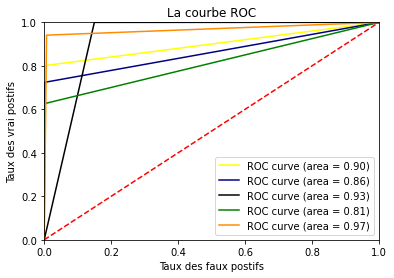

In [46]:
plt.figure()

plt.plot(fpr[0], tpr[0], color = "yellow",label='ROC curve (area = %0.2f)' %  roc_auc[0])
plt.plot(fpr[1], tpr[1], color = "navy",label='ROC curve (area = %0.2f)' %  roc_auc[1])
plt.plot(fpr[2], tpr[2], color = "black",label='ROC curve (area = %0.2f)' %  roc_auc[2])
plt.plot(fpr[3], tpr[3], color = "green",label='ROC curve (area = %0.2f)' %  roc_auc[3])
plt.plot(fpr[4], tpr[4], color = "darkorange",label='ROC curve (area = %0.2f)' %  roc_auc[4])

plt.plot([0, 1], [0, 1],'r--')
plt.xlim([0.0, 1])
plt.ylim([0.0, 1])
plt.xlabel('Taux des faux postifs')
plt.ylabel('Taux des vrai postifs')
plt.title('La courbe ROC')
plt.legend(loc="lower right")
plt.savefig('Log_ROC')
plt.show()

A partir des matrices de confusion distinguant les vrais/faux positifs/négatifs, nous avons pu construire les courbes ROC pour chaque catégorie afin de comparer lesquelles ont le plus de valeurs bien classées, dans le cadre du modèle de Random Forest non balanced.

Si les courbes coïncidaient avec la diagonale, alors le score ne serait pas plus performant que des classes prises aléatoirement.
De plus, on sait que plus la courbe ROC s'approchera du coin supérieur gauche, meilleur sera le modèle (car il captera le plus possible de vrais positifs, c'est-à-dire de mots bien classés, avec le moins possible de faux positifs). 
Ici, nous pouvons remarquer que les courbes ont toutes une forme en 'coude' et sont situées vers la partie supérieure gauche.
Cela signifie aussi que le modèle estime très bien 
On analyse donc l'AUC (l'aire sous la courbe) et on constate que la plupart des mots dans toutes les catégories sont plutôt bien classés, en particulier la catégorie 5. On a des résultats plutôt homogènes.

Néanmoins, il est intéressant de constater que d'après la courbe ROC, les classes les mieux prédites (la 5e, puis la 3e et enfin la 1ere) ne correspondent pas tout à fait à ce qu'on avait observé dans la matrice de confusion (où la mieux prédite était la classe 3 bien prédite à 100%, puis la 5 et enfin la 1ere. 
Toutefois, la 4e clase est dans tous les cas la moins bien prédite. 

# Conclusion.

Dans ce projet, nous avons donc finalement trouvé un modèle qui nous permettait de bien prédire à quelle catégorie appartenait nos tweets (par le modèle de Random Forest, non balanced). 
Nous avons néanmoins eu quelques difficultés avec des codes qui avaient parfois de très longs temps de calcul (pour trouver notamment le nombre de voisins idéal ainsi que le nombre d'abres dans la Random Forest, ou encore les SVM). 
Ce projet nous a permis d'aborder le NLP qui était nouveau pour nous, et d'adapter les méthodes que nous connaissions à ce type de données particulier. 
De plus, le fait d'avoir une classification multiclasses nous a aussi demandé d'adapter les méthodes existant initialement pour la classification binaire. 